In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import models,layers

In [3]:
img_w = 200
img_h = 200
img_size = (img_w,img_h)

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory("data")
data

Found 7553 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = data.class_names
len(data)

237

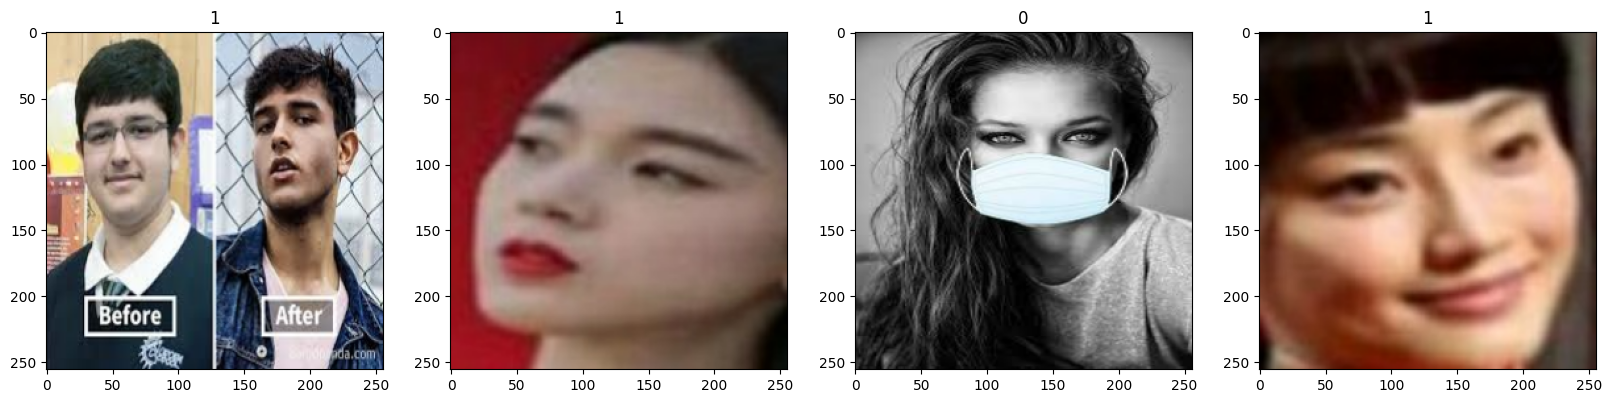

In [14]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))

for img , label in data.take(1):             # label is tensor so converting into .numpy()
    ax[0].imshow(img[0].numpy().astype(int))
    ax[0].title.set_text(label[0].numpy())
    ax[1].imshow(img[1].numpy().astype(int))
    ax[1].title.set_text(label[1].numpy())
    ax[2].imshow(img[2].numpy().astype(int))
    ax[2].title.set_text(label[2].numpy())
    ax[3].imshow(img[3].numpy().astype(int))
    ax[3].title.set_text(label[3].numpy())

In [19]:
def train_val_test(data , train=0.7 ,val=0.2,test=0.1):
    train_size = int(len(data)*train)
    val_size = int(len(data)*val)
    test_size = int(len(data)*test)
    train_data = data.take(train_size)
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size+val_size).take(test_size)
    return train_data,val_data,test_data


In [20]:
train , val ,test = train_val_test(data)

In [24]:
train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_w,img_h),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# flip_and_rotation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

In [69]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,img_w,img_h,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(2,activation='softmax')
])

In [70]:
model.build(input_shape=(32,img_w,img_h,3))

In [71]:
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (200, 200, 3)             0         
                                                                 
 conv2d_32 (Conv2D)          (32, 198, 198, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (32, 99, 99, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (32, 97, 97, 64)          18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (32, 48, 48, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (32, 46, 46, 128)        

In [73]:
hist = model.fit(
    train,
    epochs = 20,
    batch_size  = 32,
    verbose = 1,
    validation_data = val,
)

Epoch 1/20


165/165 [==============================] - 245s 1s/step - loss: 0.5001 - accuracy: 0.7538 - val_loss: 0.3686 - val_accuracy: 0.8564
Epoch 2/20
165/165 [==============================] - 244s 1s/step - loss: 0.3801 - accuracy: 0.8384 - val_loss: 0.3722 - val_accuracy: 0.8537
Epoch 3/20
165/165 [==============================] - 246s 1s/step - loss: 0.3469 - accuracy: 0.8530 - val_loss: 0.3423 - val_accuracy: 0.8617
Epoch 4/20
165/165 [==============================] - 249s 2s/step - loss: 0.3120 - accuracy: 0.8748 - val_loss: 0.3311 - val_accuracy: 0.8617
Epoch 5/20
165/165 [==============================] - 255s 2s/step - loss: 0.3058 - accuracy: 0.8767 - val_loss: 0.3027 - val_accuracy: 0.8763
Epoch 6/20
165/165 [==============================] - 250s 2s/step - loss: 0.2997 - accuracy: 0.8811 - val_loss: 0.2806 - val_accuracy: 0.8916
Epoch 7/20
165/165 [==============================] - 253s 2s/step - loss: 0.2716 - accuracy: 0.8958 - val_loss: 0.2578 - val_accuracy: 0.8996
Epoch 8/20

In [74]:
model.evaluate(test)

23/23 [==============================] - 17s 408ms/step - loss: 0.1340 - accuracy: 0.9511


[0.1339995414018631, 0.9510869383811951]

In [75]:
def model_predict(model , image):
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    image_arr = tf.expand_dims(image_arr,0)

    prediction = model.predict(image_arr)
    predict_class = class_names[np.argmax(prediction)]
    confidence = int(np.max(prediction)*100)

    return predict_class , confidence

1/1 [==============================] - 0s 32ms/step


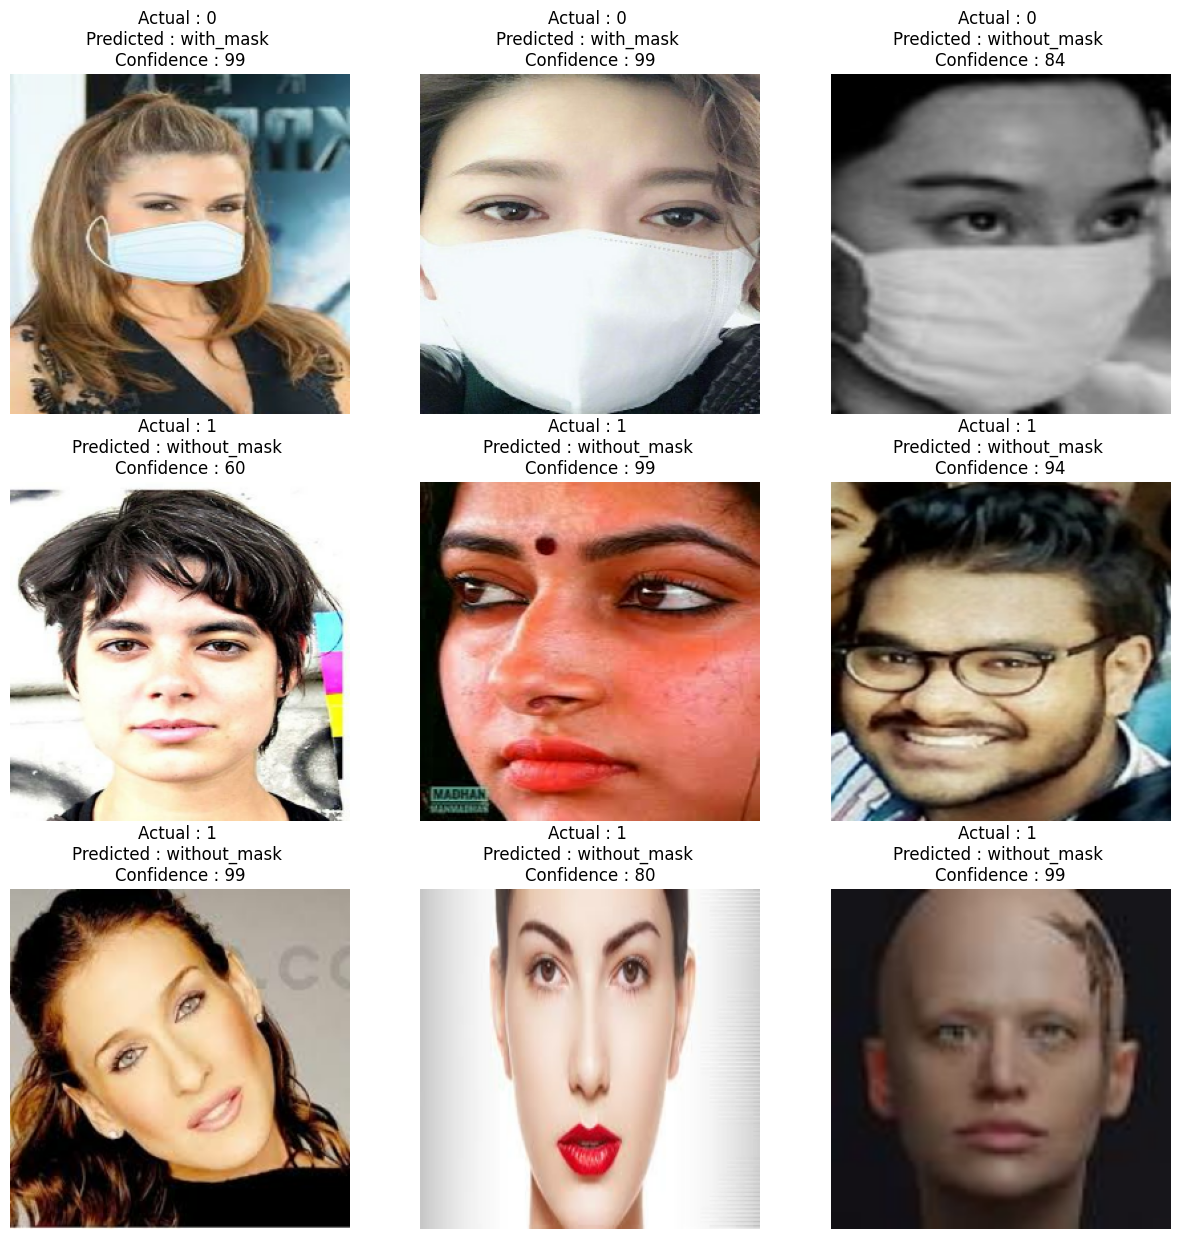

In [80]:
plt.figure(figsize=(15,15))
for img , labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        predicted_class , confidence = model_predict(model,img[i].numpy())
        plt.imshow(img[i].numpy().astype(int))
        plt.title(f"Actual : {labels[i].numpy()} \nPredicted : {predicted_class} \nConfidence : {confidence}")
        plt.axis('off')

In [81]:
model.save("face_mask_dector.h5")